In [1]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(allow_growth=True)
sess_config = tf.ConfigProto(gpu_options=gpu_options)
tf.keras.backend.set_session(tf.Session(config=sess_config))

In [2]:
import os
import glob
#import tqdm
import numpy as np
#import pandas as pd
import multiprocessing
import pydicom as dicom
import nibabel as nib
#from keras import utils as kutils
from matplotlib import pyplot as plt

def load_image(label_fpath, transpose=False):
    #encode_name = label_fpath[-39: -7]
    label_data = nib.load(label_fpath)
    label_array = label_data.get_fdata()
    if transpose:
        label_array = np.transpose(label_array, axes=(2, 1, 0))
    return  label_array#, encode_name

In [3]:
import pandas as pd
info = pd.read_csv('/data2/pancreas/Nifti_data/data_list.csv')

info['total'] = [1]*len(info)
pd.DataFrame(info.groupby(['cut', 'type']).sum().total)

total
cut   type          
fine  healthy    102
      tumor       44
thick healthy     82
      tumor      197

In [4]:
cd ..

/home/u/wartytw


In [35]:
import pandas as pd
info = pd.read_csv('/data2/pancreas/Nifti_data/data_list.csv')
image_path = "/data2/pancreas/Nifti_data/image"
label_path = "/data2/pancreas/Nifti_data/label"


shape = np.load("Resection_stage1/shape.npz.npy")
resec = np.load("Resection_stage1/resec.npy")
y = np.load("Resection_stage1/resec_y.npy")
tumor_shape = np.load("Resection_stage1/shape_tumor.npy")

In [6]:

#summarize
from skimage import measure            # to find shape contour
import scipy.ndimage as ndi            # to determine shape centrality
from skimage.feature import corner_harris, corner_subpix, corner_peaks, CENSURE
#img = tumor_img[..., 50]

def set_to_100(vec):
    vs = vec.shape[0]
    if (vs < 100):
        r = 100 - vs
        tmp = np.zeros((r, vec.shape[1]))-1
        vec = np.concatenate(( vec.reshape(-1, vec.shape[1]), tmp), axis = 0)
    
    vec = vec[tuple(list(np.round(np.linspace(1, vec.shape[0] - 1, 100)).astype(int) )), :]    
    return vec
#closing

def isZero(vec):
    if (vec == []):
        return True
    return False

def cont(img):
    return max(measure.find_contours(img, .8), key=len)

# let us set the 'brush' to a 6x6 circle
struct = [[ 0., 0., 1., 1., 0., 0.],
          [ 0., 1., 1., 1., 1., 0.],  
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 1., 1., 1., 1., 1., 1.], 
          [ 0., 1., 1., 1., 1., 0.],
          [ 0., 0., 1., 1., 0., 0.]]

num = 80

#closing = cont(ndi.morphology.binary_closing(img > num, structure=struct).astype(img.dtype))


In [7]:
def set_to_pixel2(tumor_img, mor_type, num_slice):
    pixel_t = np.zeros((mor_type.shape[0], 1))
    for i in range(mor_type.shape[0]):
        pixel_t[i] = tumor_img[mor_type[i, 0],mor_type[i, 1] , num_slice]
    return pixel_t

def set_to_pixel1(tumor_img, mor_type, num_slice):
    pixel_t = np.zeros((mor_type.shape[0], 1))
    for i in range(mor_type.shape[0]):
        pixel_t[i] = tumor_img[mor_type[i, 0], num_slice, mor_type[i, 1] ]
    return pixel_t

def set_to_pixel0(tumor_img, mor_type, num_slice):
    pixel_t = np.zeros((mor_type.shape[0], 1))
    for i in range(mor_type.shape[0]):
        pixel_t[i] = tumor_img[ num_slice, mor_type[i, 0],mor_type[i, 1] ]
    return pixel_t


#New
def extract_cube(r, img):#cube 210, 220, 90 ;; ranges = [xmin, xmax, ymin, ymax, zmin, zmax]
    img_tmp = np.zeros((356, 289, 105))
    #print(img.shape, r)
    img_tmp[:int(r[1]-r[0]), :int(r[3]-r[2]), :int(r[5]-r[4])] = img[int(r[0]):int(r[1]), int(r[2]):int(r[3]), int(r[4]):int(r[5])]
    return img_tmp


def masking(label, img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if label[i, j] == 0 or label[i, j] == 1:
                img[i, j] = 0
    return img

def masking2(label, img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if label[i, j] != 1:
                img[i, j] = 0
    return img

import pandas as pd
map_df = pd.DataFrame(data={'resec_name': resec, 'shape': np.array(range(182)), 'target':y.reshape(182)})


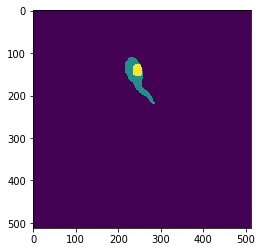

In [22]:
plt.imshow(label[..., 71])

In [8]:
tumor_shape2 = np.zeros((len(resec), 6))
for i , name in enumerate(resec[:1]):
    label = load_image(os.path.join(label_path, "LB_" + name + ".nii.gz"))
    for j in range(3):
        tumor_shape2[i, j*2] = np.min(np.unique(np.where(label != 0)[j]))
        tumor_shape2[i, j*2+1] = np.max(np.unique(np.where(label != 0)[j]))
    del label


In [11]:
tumor_shape2

array([[103., 312., 214., 318.,  55.,  73.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.]])

In [12]:
name = resec[0]

In [13]:
img = load_image(os.path.join(image_path, "IM_" + name + ".nii.gz"))
label = load_image(os.path.join(label_path, "LB_" + name + ".nii.gz"))


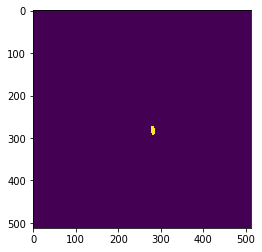

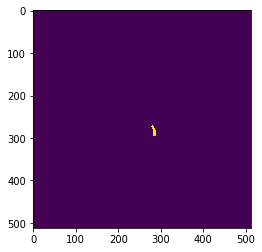

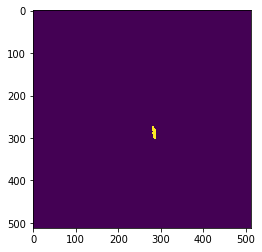

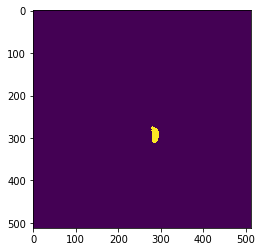

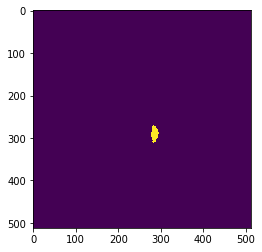

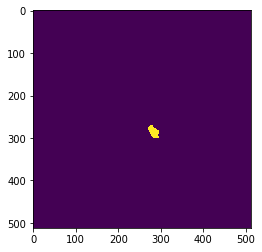

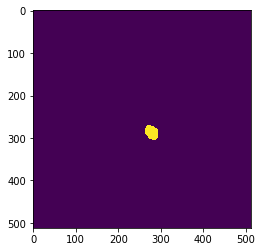

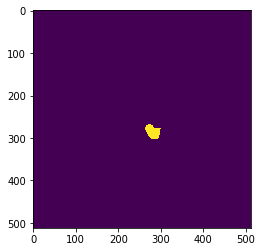

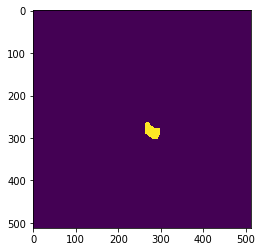

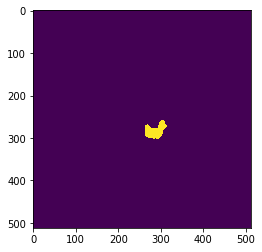

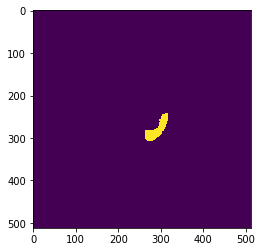

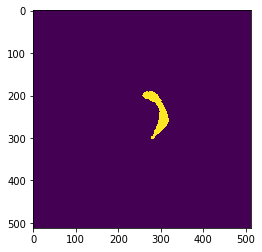

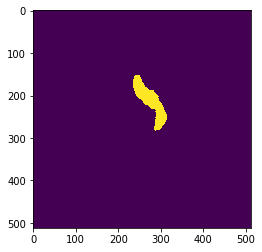

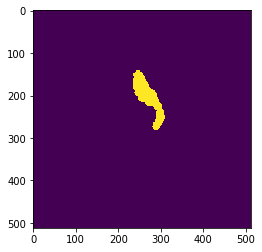

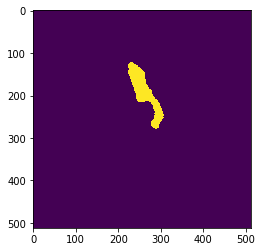

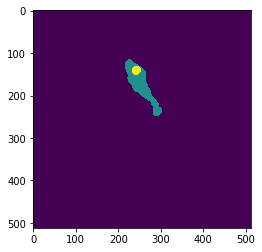

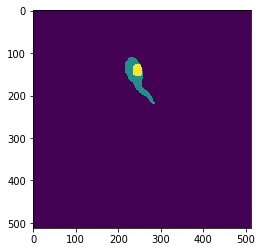

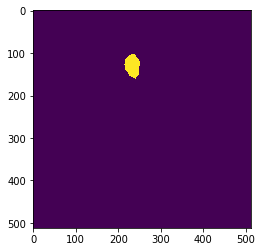

In [14]:
for i in range(55, 73):
    plt.imshow(label[..., i])
    plt.show()

59

In [18]:
#create 3 contours in 3 dimensions
#182 identities in total 
#1. crop into (210, 220, 90) -> dilation ->masking
#2. erosion for each 60, 70, 80
#3. store in contours[182, 3, n_{dimension} , 3, 100] #identity, dimension, num_slcie,  contour  ;; num_slice = [210, 200, 90]
num_identity = len(resec)
contours = np.zeros((num_identity, 3, 365, 3, 100))
contour_position = np.zeros((num_identity, 1, 365, 6, 100))
from scipy import ndimage



nums = [60, 70, 80]
for idx, name in enumerate(resec):
    print(idx)
    img = load_image(os.path.join(image_path, "IM_" + name + ".nii.gz"))
    label = load_image(os.path.join(label_path, "LB_" + name + ".nii.gz"))
    img = extract_cube(tumor_shape[idx], img)
    label = extract_cube(tumor_shape[idx], label)

#========
    for i in range(img.shape[2]):
        
        num_slice = i
        label[..., i] = masking(label[..., i], label[..., i])
        label[..., i] = ndimage.binary_dilation(label[..., i]).astype(label[..., i].dtype)
        img[..., i] = masking2(label[..., i], img[..., i])
        for n, num in enumerate(nums):

            o1 = measure.find_contours(ndi.morphology.binary_closing(img[..., i] > num, structure=struct).astype(img.dtype), .8)
            if(isZero(o1)):
                contours[idx, 2, i, n, :] = np.zeros((100,))
            else:
                closing = cont(ndi.morphology.binary_closing(img[..., i] > num, structure=struct).astype(img[..., i].dtype))
                contour_position[idx, 0, i, 2*n:2*(n+1), :] = set_to_100(closing).reshape(2, 100)
                tmp_vector = set_to_pixel2(img, closing.astype(np.int), i)
                contours[idx, 2, i, n, :] = set_to_100(tmp_vector).reshape(100)


#===========      
    for i in range(img.shape[1]):
        num_slice = i
        label[:, i, :] = masking(label[:, i, :], label[:, i, :])
        label[:, i, :] = ndimage.binary_dilation(label[:, i, :]).astype(label[:, i, :].dtype)
        img[:, i, :] = masking2(label[:, i, :], img[:, i, :])
        for n, num in enumerate(nums):

            o1 = measure.find_contours(ndi.morphology.binary_closing(img[:, i, :] > num, structure=struct).astype(img.dtype), .8)
            if(isZero(o1)):
                contours[idx, 1, i, n, :] = np.zeros((100,))
            else:
                closing = cont(ndi.morphology.binary_closing(img[:, i, :] > num, structure=struct).astype(img[:, i, :].dtype))
                tmp_vector = set_to_pixel1(img, closing.astype(np.int), i)
                contours[idx, 1, i, n, :] = set_to_100(tmp_vector).reshape(100)
        
#===========    
    for i in range(img.shape[0]):
        
        num_slice = i
        label[i, :, :] = masking(label[i, :, :], label[i, :, :])
        label[i, :, :] = ndimage.binary_dilation(label[i, :, :]).astype(label[i, :, :].dtype)
        img[i, :, :] = masking2(label[i, :, :], img[i, :, :])
        for n, num in enumerate(nums):

            o1 = measure.find_contours(ndi.morphology.binary_closing(img[i, :, :] > num, structure=struct).astype(img.dtype), .8)
            if(isZero(o1)):
                contours[idx, 0, i, n, :] = np.zeros((100,))
            else:
                closing = cont(ndi.morphology.binary_closing(img[i, :, :] > num, structure=struct).astype(img[i, :, :].dtype))
                tmp_vector = set_to_pixel1(img, closing.astype(np.int), i)
                contours[idx, 0, i, n, :] = set_to_100(tmp_vector).reshape(100)
                
        
    del img, label

   




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181


In [142]:
#contours[182, 3, n_{dimension} , 3, 100] 
num_slice_nonzero_contours = []
for i in range(182):
    num_slice_nonzero_contours.append(np.unique(np.where(contours[i, ...]!= 0)[1]).shape[0])

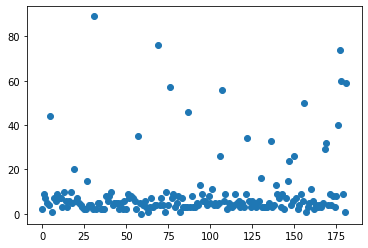

In [146]:
plt.scatter(list(range(len(num_slice_nonzero_contours))), num_slice_nonzero_contours)

In [147]:
np.median(num_slice_nonzero_contours)

5.0

In [129]:
contours[0, 2, 16, 1, :]

array([ 92., 111., 106., 103., 118., 109., 126.,   0., 125., 130.,   0.,
       126., 136., 117.,   0., 116.,   0.,   0., 129.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  96.,
         0., 100.,   0.,  89.,  75.,  61.,  61.,  68.,  61.,  72.,  91.,
         0.,  78.,   0.,  92.,  87.,   0.,  80.,  81.,  86.,  86.,  61.,
        65.,  78.,  53.,   0.,  82.,  85.,  80.,  84.,  84., 108., 111.,
       111.,  99.,  99.,  89.,  89.,  89.,  89., 100.,  58.,  68.,  78.,
        78.])

In [136]:
name = resec[2]
img = load_image(os.path.join(image_path, "IM_" + name + ".nii.gz"))
label = load_image(os.path.join(label_path, "LB_" + name + ".nii.gz"))
np.where(label != 0)
#plt.imshow(img[])
# plt.show()

(array([193, 193, 193, ..., 308, 308, 308]),
 array([295, 296, 297, ..., 303, 304, 305]),
 array([67, 67, 67, ..., 62, 62, 62]))

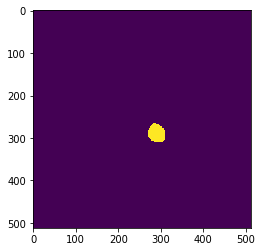

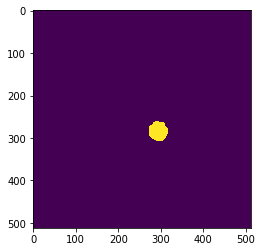

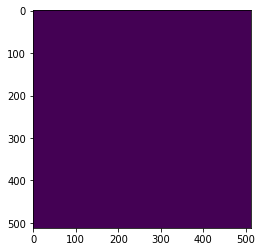

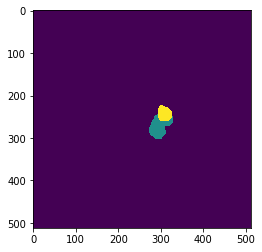

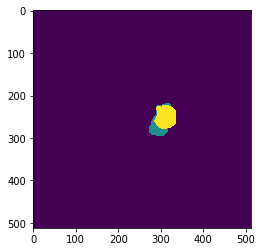

In [137]:
for i in range(62, 67):
    plt.imshow(label[..., i])
    plt.show()

In [92]:
tumor_shape2

array([[103., 312., 214., 318.,  55.,  73.],
       [177., 333., 221., 342.,  25.,  34.],
       [193., 308., 270., 336.,  59.,  72.],
       ...,
       [161., 321., 264., 345.,  15.,  29.],
       [126., 295., 290., 367.,  13.,  27.],
       [116., 317., 188., 339., 216., 308.]])

In [75]:
name = resec[0]
img = load_image(os.path.join(image_path, "IM_" + name + ".nii.gz"))
label = load_image(os.path.join(label_path, "LB_" + name + ".nii.gz"))
img = extract_cube(tumor_shape2[0], img)
label = extract_cube(tumor_shape2[0], label)

In [76]:
np.unique(np.where(label != 0)[0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

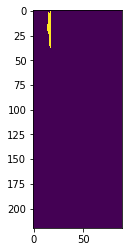

In [82]:
plt.imshow(label[20, ...])

In [91]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)

In [89]:
del binary_accuracy

In [114]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate,  MaxPool2D
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv1D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras import metrics
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector, Reshape
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import keras

In [127]:
inputA = Input(shape=(220, 3, 100,1 ))
init = 'sigmoid'
tmp_x = TimeDistributed(Conv2D(64, (3, 3), padding = 'same',  activation = init), input_shape = (220, 3, 100,1 ))(inputA)
x = TimeDistributed(Conv2D(64, (3, 3), 
                                 kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu'))(tmp_x)
x = Dropout(0.5)(x)

x = TimeDistributed(Conv2D(32, (3, 3), 
                                 kernel_initializer = tf.keras.initializers.glorot_normal(seed=None),padding = 'same', activation = init))(x)
x = TimeDistributed(Conv2D(32, (3, 3), 
                                 kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu',padding = 'same'))(x)

x = Dropout(0.5)(x)


x = TimeDistributed(Conv2D(16, (3, 3), 
                                 kernel_initializer = tf.keras.initializers.glorot_normal(seed=None),padding = 'same', activation = init))(x)
x = TimeDistributed(Conv2D(16, (3, 3), 
                                 kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu',padding = 'same'))(x)

x = Dropout(0.5)(x)

x = TimeDistributed(Conv2D(8, (3, 3), 
                                 kernel_initializer = tf.keras.initializers.glorot_normal(seed=None),padding = 'same', activation = init))(x)
x = TimeDistributed(Conv2D(8, (3, 3), 
                                 kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu',padding = 'same'))(x)
x = Dropout(0.5)(x)



#x = concatenate([x, tmp_x], axis = -1)
x = TimeDistributed(Flatten())(x)
x = TimeDistributed(Dense(150,kernel_initializer = keras.initializers.he_normal(seed=None), activation='sigmoid'))(x)
x = Dropout(0.5)(x)


x = LSTM(150, return_sequences = False, dropout = 0.5)(x)
x = Dropout(0.5)(x)
x = Model(inputs=inputA, outputs=x)

#==========
inputB = Input(shape=(6,))
tmp_y = Dense(100,kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu')(inputB)
y = Dropout(0.5)(tmp_y)
y = Dense(50,kernel_initializer = keras.initializers.he_normal(seed=None), activation='relu')(y)
y = Dropout(0.5)(y)

y = Dense(1 ,kernel_initializer = keras.initializers.he_normal(seed=None), activation='selu')(y)
y = concatenate([y, inputB])
y = Model(inputs=inputB, outputs=y)

#========
combined = concatenate([x.output, y.output])
#=======

z = Dense(151,kernel_initializer = tf.keras.initializers.glorot_normal(seed=None), activation=init)(combined)
z = Dropout(0.5)(z)
z = Dense(10,kernel_initializer = tf.keras.initializers.glorot_normal(seed=None), activation="selu")(z)
z = Dense(1, activation='sigmoid')(z)
#========
model = Model(inputs=[x.input, y.input], outputs=z)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 220, 3, 100,  0                                            
__________________________________________________________________________________________________
time_distributed_82 (TimeDistri (None, 220, 3, 100,  640         input_21[0][0]                   
__________________________________________________________________________________________________
time_distributed_83 (TimeDistri (None, 220, 1, 98, 6 36928       time_distributed_82[0][0]        
__________________________________________________________________________________________________
dropout_80 (Dropout)            (None, 220, 1, 98, 6 0           time_distributed_83[0][0]        
__________________________________________________________________________________________________
time_distr

In [128]:
adam_lr = 0.0002
adam_beta_1 = 0.5
model.compile(optimizer=Adam(lr=adam_lr, beta_1=adam_beta_1),
              loss='binary_crossentropy', metrics = [binary_accuracy])


In [50]:
contours[:-50, 2, :220,  :, :].shape

(132, 220, 3, 100)

In [51]:
np.expand_dims(contours[:-50, 2, :220, :, :], axis = 5).shape

/opt/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.


(132, 220, 3, 100, 1)

In [55]:
np.expand_dims(tumor_shape, axis = 2).shape

(182, 6, 1)

In [131]:
y = np.load("Resection_stage1/resec_y.npy")

In [132]:
# model.fit( tumor_shape[:-50, :], y[:-50], epochs = 10, batch_size = 2)

In [129]:
# model.fit([np.expand_dims(contours[:-50, 2, :220, :, :], axis = 5), tumor_shape[:-50, :]], y[:-50], epochs = 10, batch_size = 2)

In [135]:
hist = model.fit([np.expand_dims(contours[:-30, 2, :220, :, :], axis = 5), tumor_shape[:-30, :]], y[:-30], epochs = 100, batch_size = 2, validation_split=0.15)

/opt/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.


Train on 129 samples, validate on 23 samples
Epoch 1/100
129/129 [==============================] - 31s 239ms/step - loss: 0.6422 - binary_accuracy: 0.6589 - val_loss: 0.6172 - val_binary_accuracy: 0.6957
Epoch 2/100
129/129 [==============================] - 29s 229ms/step - loss: 0.6009 - binary_accuracy: 0.6899 - val_loss: 0.6000 - val_binary_accuracy: 0.6957
Epoch 3/100
129/129 [==============================] - 30s 230ms/step - loss: 0.5983 - binary_accuracy: 0.6512 - val_loss: 0.5933 - val_binary_accuracy: 0.7826
Epoch 4/100
129/129 [==============================] - 29s 225ms/step - loss: 0.6168 - binary_accuracy: 0.6822 - val_loss: 0.6182 - val_binary_accuracy: 0.6957
Epoch 5/100
129/129 [==============================] - 30s 230ms/step - loss: 0.5992 - binary_accuracy: 0.6822 - val_loss: 0.5802 - val_binary_accuracy: 0.7391
Epoch 6/100
129/129 [==============================] - 29s 227ms/step - loss: 0.5717 - binary_accuracy: 0.7287 - val_loss: 0.6014 - val_binary_accuracy: 0.

Epoch 52/100
129/129 [==============================] - 29s 223ms/step - loss: 0.4456 - binary_accuracy: 0.8062 - val_loss: 0.6371 - val_binary_accuracy: 0.7391
Epoch 53/100
129/129 [==============================] - 29s 224ms/step - loss: 0.4576 - binary_accuracy: 0.8372 - val_loss: 0.6065 - val_binary_accuracy: 0.7391
Epoch 54/100
129/129 [==============================] - 29s 225ms/step - loss: 0.4588 - binary_accuracy: 0.7984 - val_loss: 0.6001 - val_binary_accuracy: 0.7391
Epoch 55/100
129/129 [==============================] - 29s 225ms/step - loss: 0.4091 - binary_accuracy: 0.8295 - val_loss: 0.5834 - val_binary_accuracy: 0.7391
Epoch 56/100
129/129 [==============================] - 29s 225ms/step - loss: 0.4242 - binary_accuracy: 0.8295 - val_loss: 0.5736 - val_binary_accuracy: 0.7391
Epoch 57/100
129/129 [==============================] - 29s 222ms/step - loss: 0.4129 - binary_accuracy: 0.8372 - val_loss: 0.5878 - val_binary_accuracy: 0.7391
Epoch 58/100
129/129 [============

In [138]:
pred = model.predict([np.expand_dims(contours[-30:, 2, :220, :, :], axis = 5), tumor_shape[-30:, :]])

/opt/anaconda3/5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.


In [139]:
np.concatenate([np.round(pred), np.array(map_df.target[-30:]).reshape(-1, 1)], axis = 1)

array([[1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [0., 1.],
       [1., 1.],
       [0., 0.],
       [0., 1.],
       [1., 1.],
       [0., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [0., 1.],
       [0., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [1., 1.],
       [0., 0.]])

In [140]:
from sklearn.metrics import confusion_matrix
confusion_matrix(map_df.target[-30:], list(np.round(pred)))

array([[13,  2],
       [ 4, 11]])

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


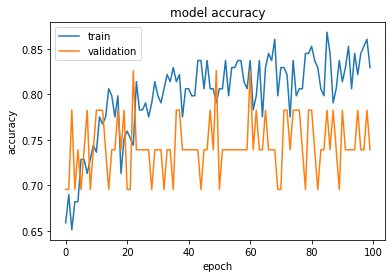

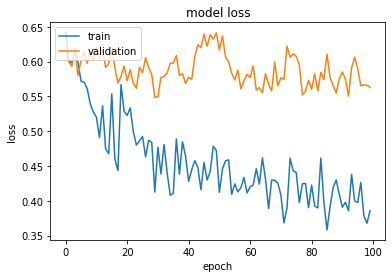

In [142]:
# list all data in history
history = hist
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()